In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import math

import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import log_loss

from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

from cycler import cycler
from colorama import Style, Fore

import warnings; warnings.filterwarnings('ignore')

sys.path.append('..')
from config import CFG, BASELINE as BL
CFG = CFG()
BL = BL()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

# Parameter Initialization

In [5]:
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

palette = ['#3c3744', '#048BA8', '#EE6352', '#E1BB80', '#78BC61']
grey_palette = ['#8e8e93', '#636366', '#48484a', '#3a3a3c', '#2c2c2e', '#1c1c27']
bg_color = '#F6F5F5'
white_color = '#d1d1d6'

custom_params = {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.left': False,
    'grid.alpha':0.2,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'ytick.labelsize': 'medium',
    'xtick.labelsize': 'medium',
    'legend.fontsize': 'large',
    'lines.linewidth': 1,
    'axes.prop_cycle': cycler('color',palette),
    'figure.facecolor': bg_color,
    'figure.edgecolor': bg_color,
    'axes.facecolor': bg_color,
    'text.color':grey_palette[1],
    'axes.labelcolor':grey_palette[1],
    'axes.edgecolor':grey_palette[1],
    'xtick.color':grey_palette[1],
    'ytick.color':grey_palette[1],
    'figure.dpi':150,
}
sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params)

# Loading Data & Feature Engineering

In [26]:
train = pd.read_csv(os.path.join(CFG.PROCESSED_DATA, 'train.csv'))
test = pd.read_csv(os.path.join(CFG.PROCESSED_DATA, 'test.csv'))

In [27]:
def fe(df):
    """
    Feature engineering: log transformation from the features found via EDA with adding the min to prevent errors
    """
    ms = df['Skewness'].min() + 0.0001
    df['Skewness'] = (df['Skewness'] + ms).apply(np.log)

    mk = df['EK'].min() + 0.0001
    df['EK'] = (df['EK'] + mk).apply(np.log)

    mcm = df['Mean_DMSNR_Curve'].min() + 0.0001
    df['Mean_DMSNR_Curve'] = (df['Mean_DMSNR_Curve'] + mcm).apply(np.log)

    sm = df['Skewness_DMSNR_Curve'].min() + 0.0001
    df['Skewness_DMSNR_Curve'] = (df['Skewness_DMSNR_Curve'] + sm).apply(np.log)

    ekm = df['EK_DMSNR_Curve'].min() + 0.0001
    df['EK_DMSNR_Curve'] = (df['EK_DMSNR_Curve'] + ekm).apply(np.log)
    return df

train = fe(train)
test = fe(test)

# Helper Functions

In [22]:
def show_confusion_roc(oof: list) -> None:
    """
    Draws a confusion matrix and roc_curve with AUC score.
    """
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    df.index = df.index.astype(int)
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, color=palette[1], ax=ax[1])
    plt.tight_layout()

def get_mean_score(oof: np.array):
    oof = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
    oof.index = oof.index.astype(int)
    return log_loss(oof.target, oof.preds)

# Baseline

In [28]:
%%time
params = {
    'learning_rate': BL.LR,
    'max_depth': BL.MDEPTH,
    'colsample_bytree': BL.COLSAMPLE,
    'n_jobs': -1,
    'objective': 'binary:logistic',
    'verbosity': 0,
    'eval_metric': 'logloss'
}
X, y = train.drop('Class', axis=1), train.Class
cv = model_selection.StratifiedKFold(n_splits=BL.NFOLDS, shuffle=True, random_state=BL.SEED)

feature_importances_ = pd.DataFrame(index=test.columns)
eval_results_ = {}
models_ = []
oof = []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
    if (fold + 1) % 5 == 0 or (fold + 1) == 1:
        print(f'{grn}Fold {fold + 1} of {BL.NFOLDS}{res}')

    X_tr = X.iloc[tr_idx]
    X_val = X.iloc[val_idx]
    y_tr = y.iloc[tr_idx]
    y_val = y.iloc[val_idx]

    train_ds = xgb.DMatrix(X_tr, label=y_tr)
    val_ds = xgb.DMatrix(X_val, label=y_val)
    watchlist = [(train_ds, 'fit'), (val_ds, 'val')]

    eval_results_[fold] = {}
    model = xgb.train(num_boost_round=BL.N_ESTIMATORS,
                      params=params,
                      dtrain=train_ds,
                      evals=watchlist,
                      evals_result=eval_results_[fold],
                      verbose_eval=False,
                      callbacks=[EarlyStopping(BL.ESR,
                                               data_name='val', save_best=True)])

    val_preds = model.predict(val_ds)
    val_score = log_loss(y_val, val_preds)
    best_iter = model.best_iteration

    idx_pred_target = np.vstack([val_idx, val_preds, y_val]).T
    print(f'{" " * 15} LogLoss:{blu}{val_score:.5f}{res} {" " * 6} best iteration  :{blu}{best_iter}{res}')

    # Stores out-of-fold preds.
    oof.append(idx_pred_target)

    # Stores the feature importances
    feature_importances_[f'gain_{fold}'] = model.get_score(importance_type='gain').values()
    feature_importances_[f'split_{fold}'] = model.get_score(importance_type='weight').values()

    # Stores the model
    models_.append(model)
    
mean_val_rmse = get_mean_score(oof)
print(f'{"*" * 45}\n{red}Mean{res} LogLoss: {red}{mean_val_rmse:.5f}')    

Fold 1 of 15
                LogLoss:0.03168        best iteration  :411
                LogLoss:0.03291        best iteration  :348
                LogLoss:0.03457        best iteration  :299
                LogLoss:0.03603        best iteration  :553
Fold 5 of 15
                LogLoss:0.03578        best iteration  :352


KeyboardInterrupt: 

# CV Analysis

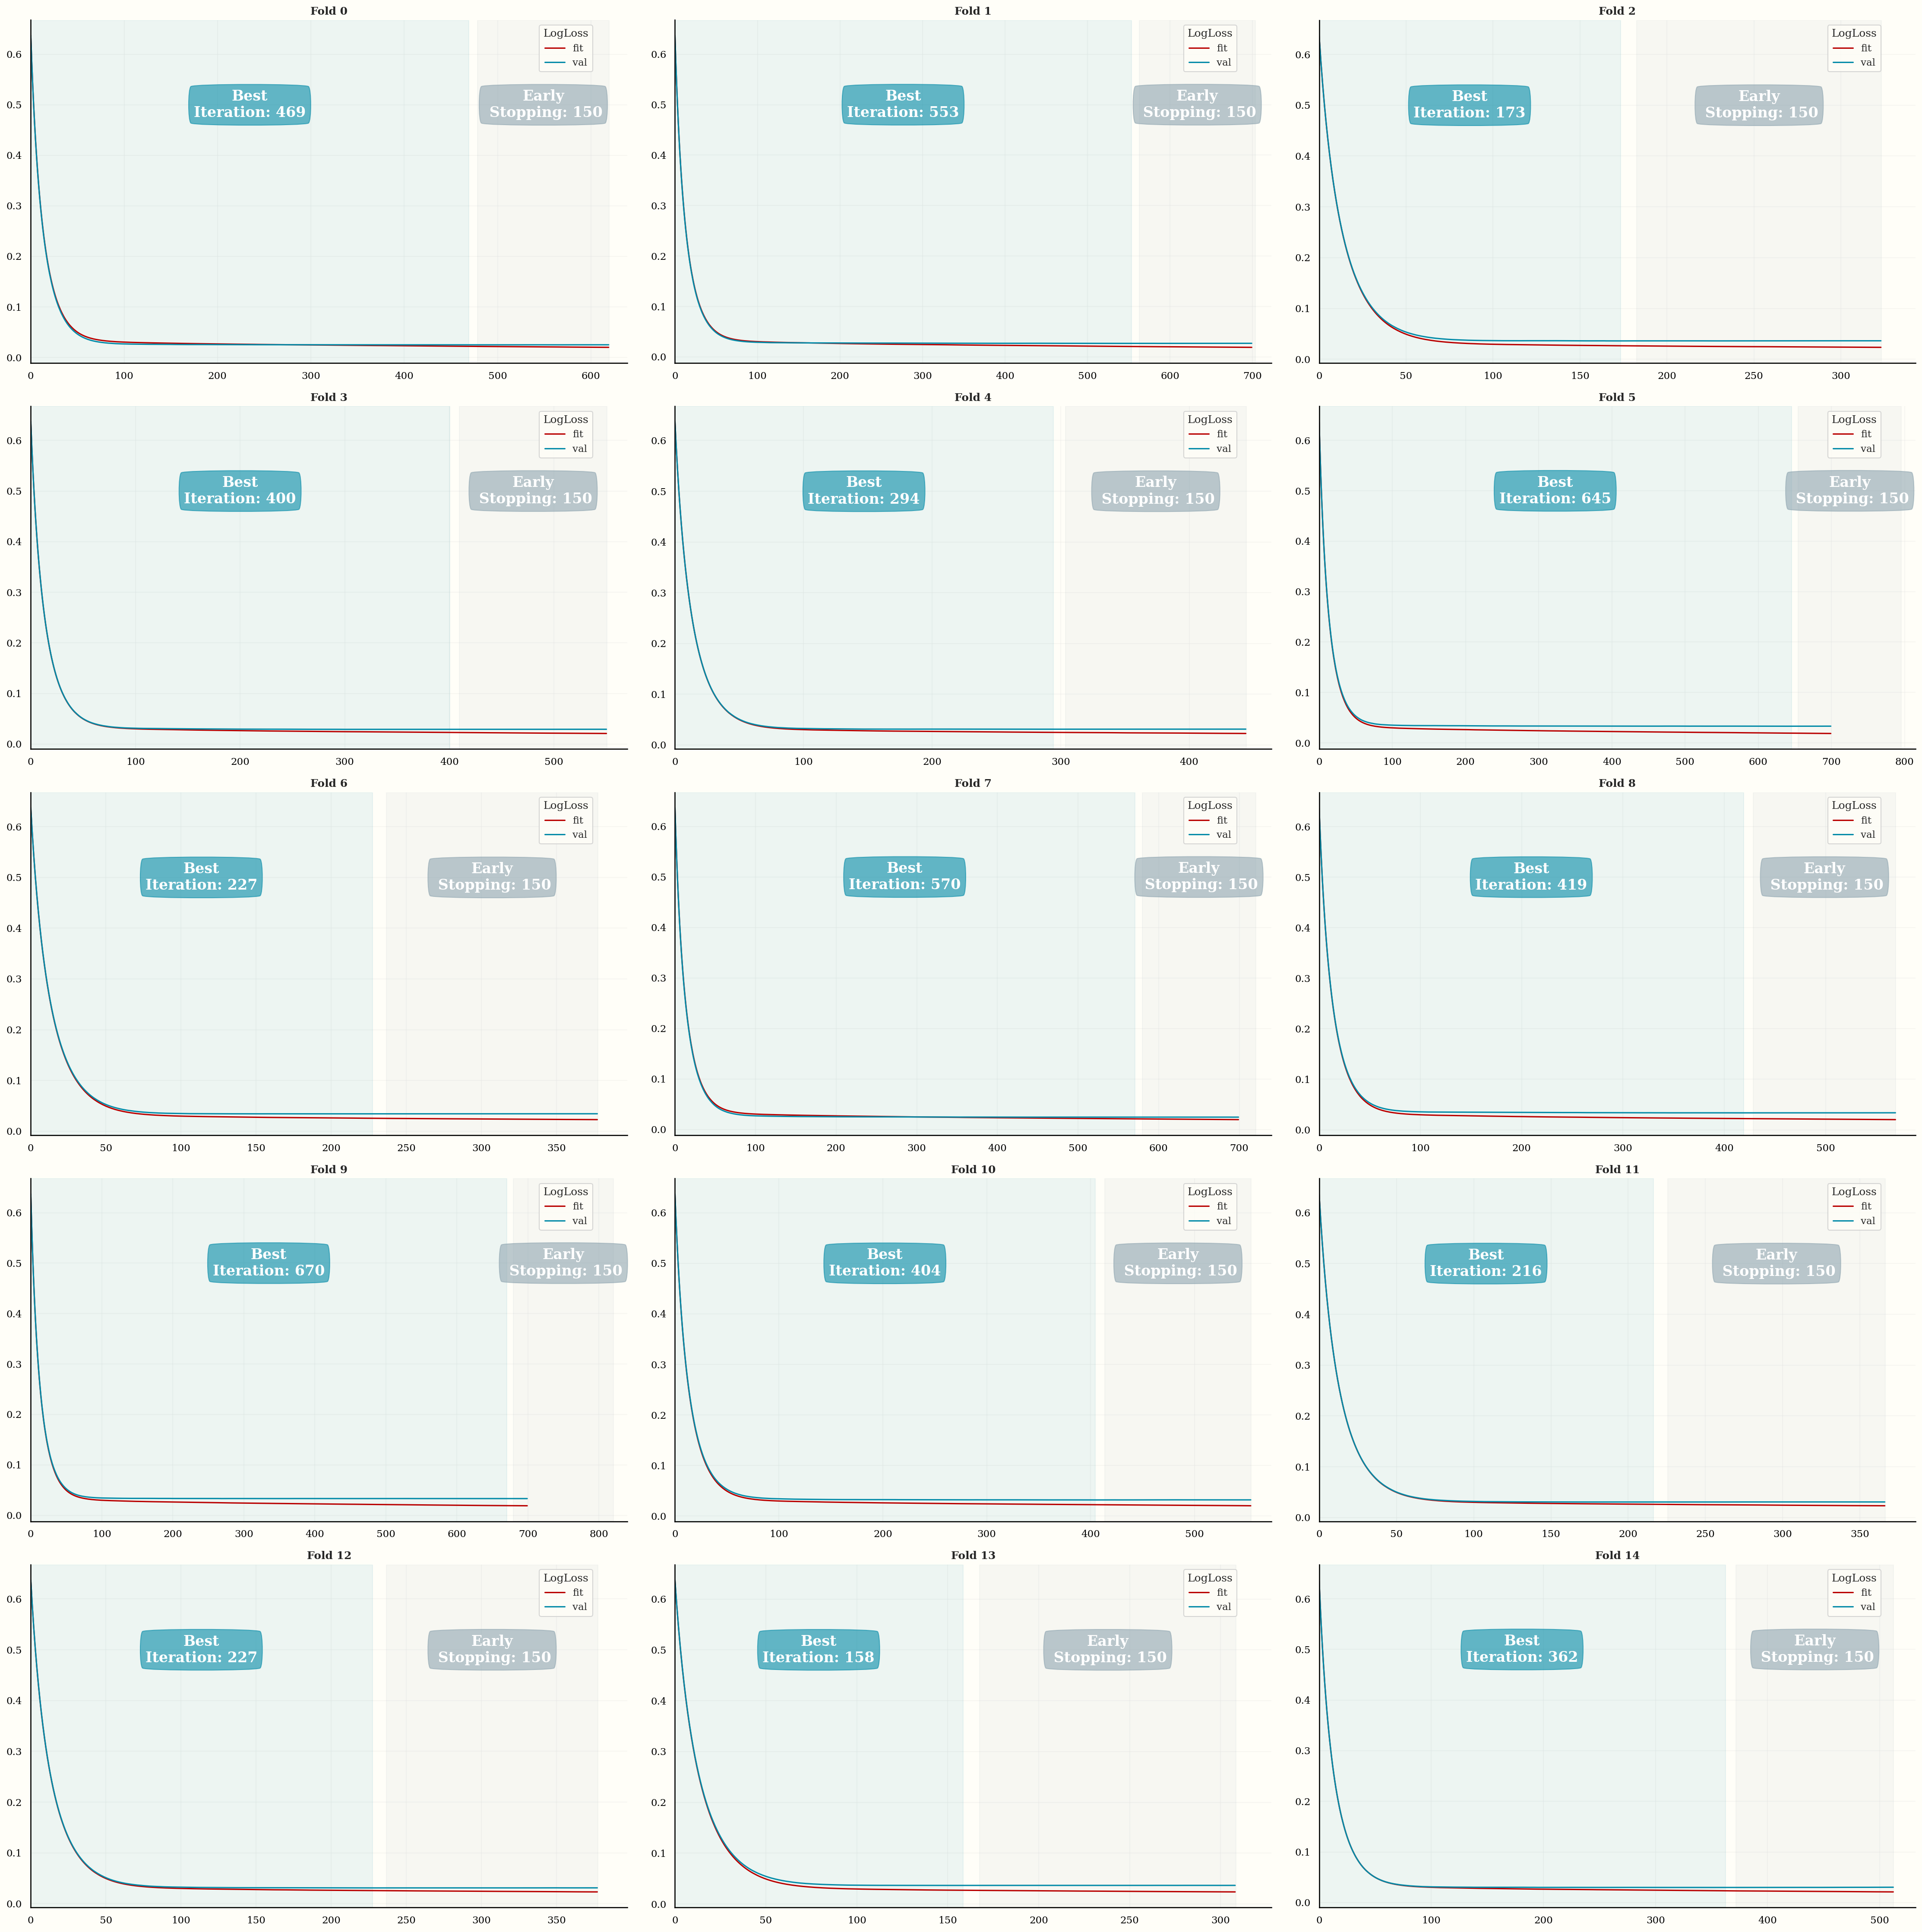

In [45]:
logloss_folds = pd.DataFrame.from_dict(eval_results_).T
fit_logloss = logloss_folds.fit.apply(lambda x: x['logloss'])
val_logloss = logloss_folds.val.apply(lambda x: x['logloss'])

fig, axes = plt.subplots(math.ceil(BL.NFOLDS/3), 3, figsize=(30, 30), dpi=150)
ax = axes.flatten()
for i, (f, v, m) in enumerate(zip(fit_logloss, val_logloss, models_)): 
    sns.lineplot(f, color='#B90000', ax=ax[i], label='fit')
    sns.lineplot(v, color='#048BA8', ax=ax[i], label='val')
    ax[i].legend()
    ax[i].set_title(f'Fold {i}', fontdict={'fontweight': 'bold'})
    
    color =  ['#048BA8', palette[-3]]
    best_iter = m.best_iteration
    span_range = [[0, best_iter], [best_iter + 10, best_iter + BL.ESR]]
    
    for idx, sub_title in enumerate([f'Best\nIteration: {best_iter}', f'Early\n Stopping: {BL.ESR}']):
        ax[i].annotate(sub_title,
                    xy=(sum(span_range[idx])/2 , 0.5),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax[i].axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.07)
    
    ax[i].set_xlim(0, best_iter + 20 + BL.ESR)
    ax[i].legend(bbox_to_anchor=(0.95, 1), loc='upper right', title='LogLoss')

plt.tight_layout();

# Feature Importance

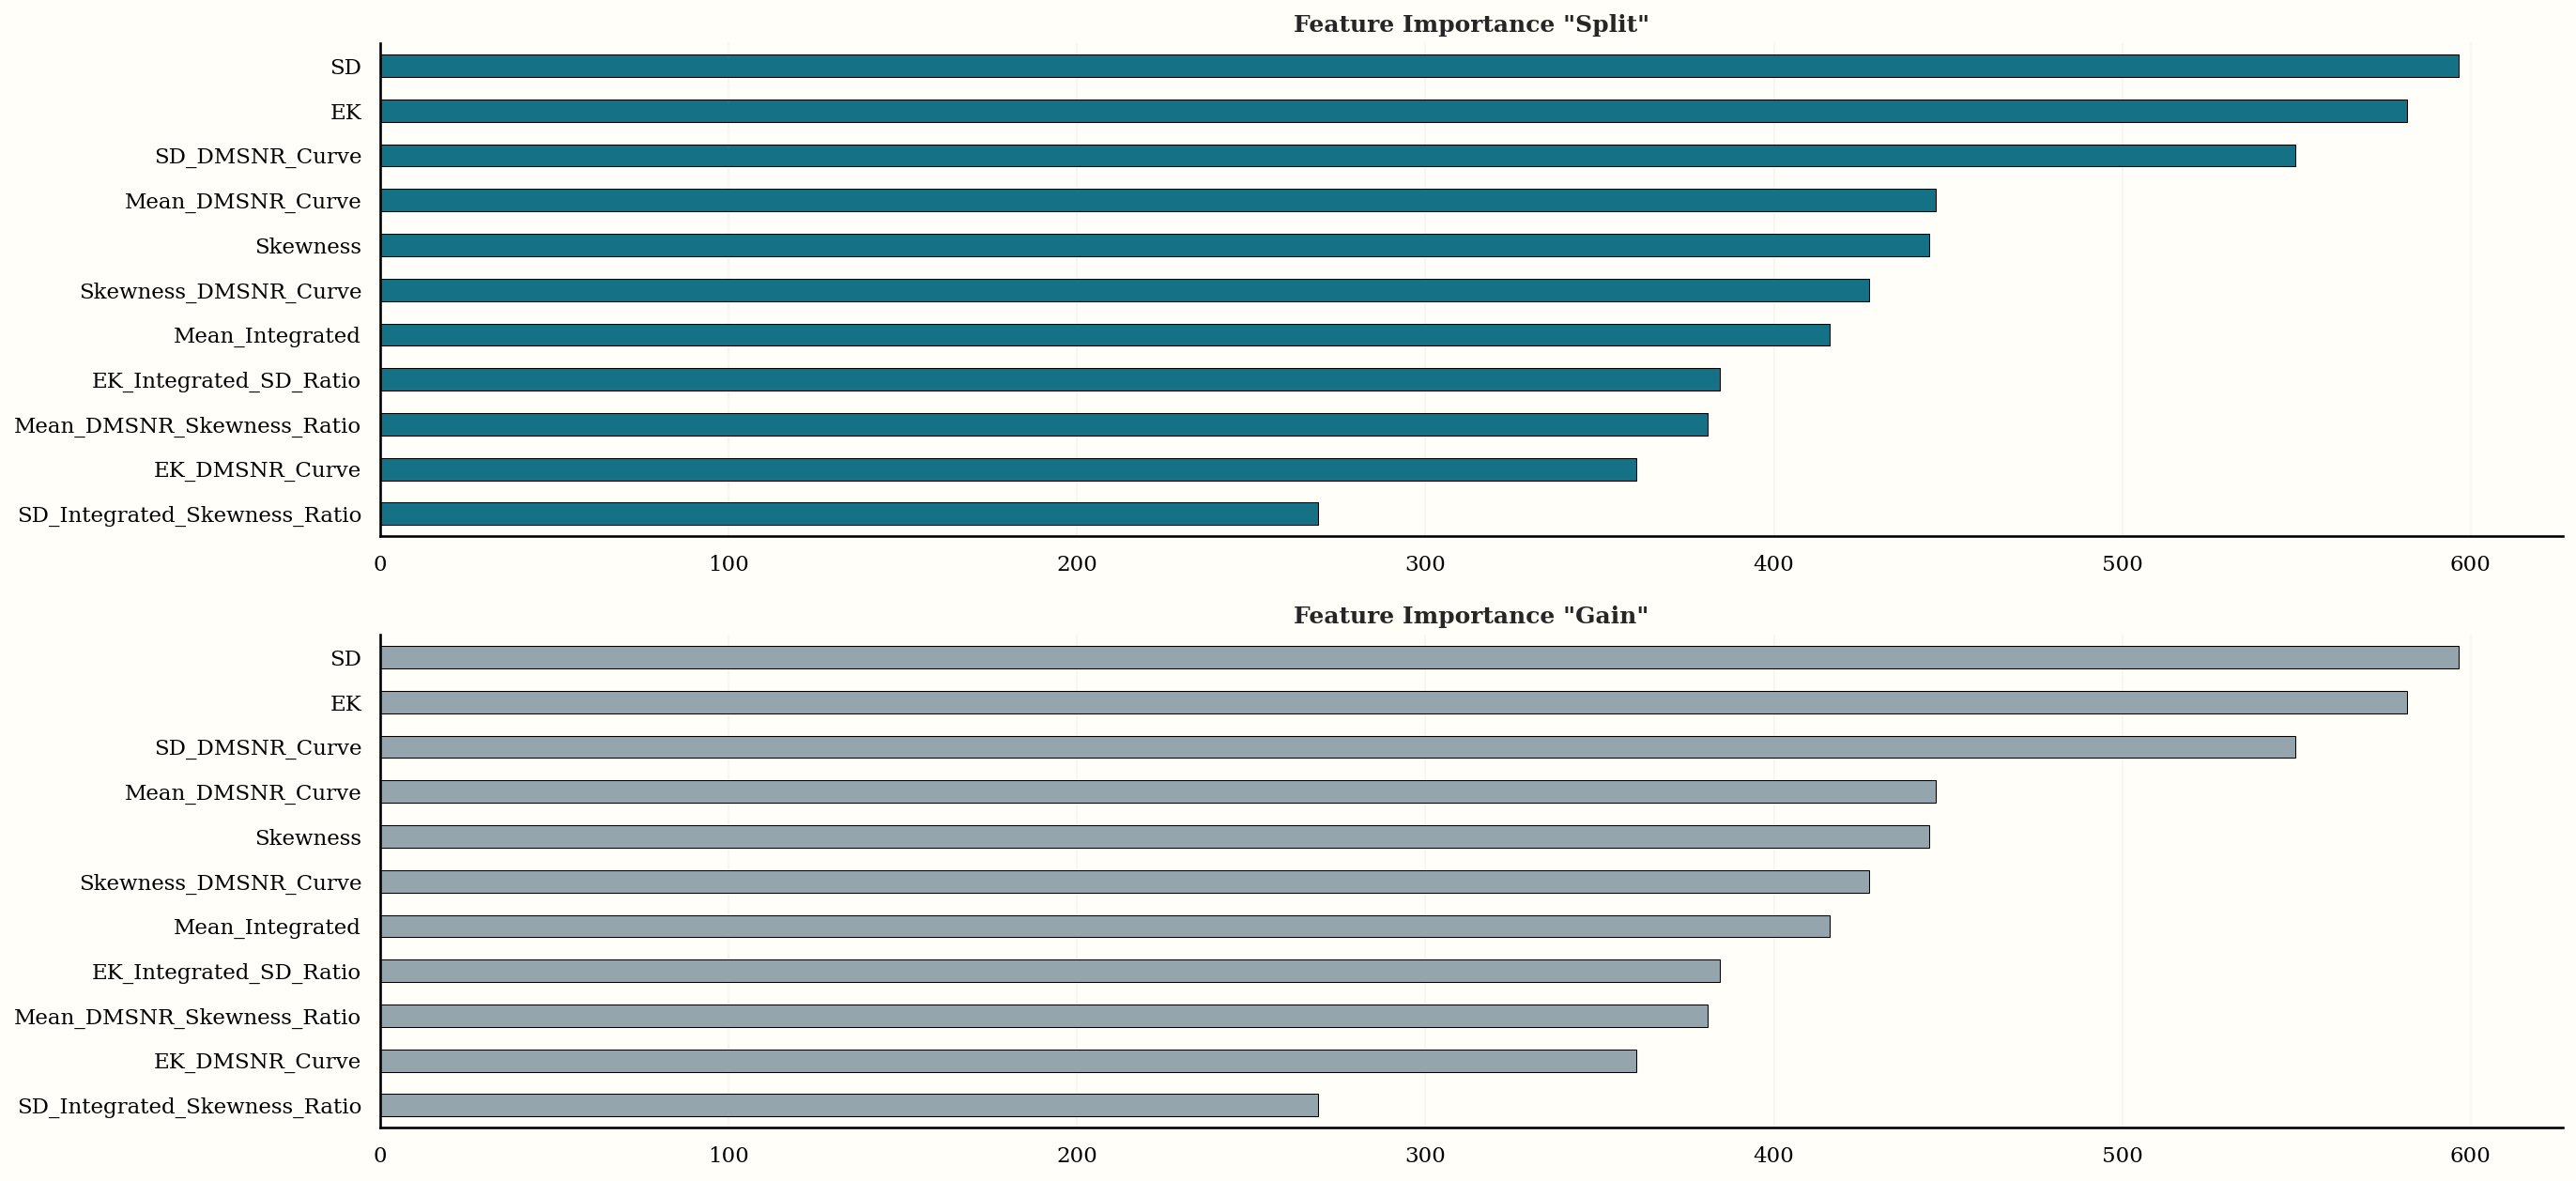

In [46]:
fi = feature_importances_
fi_gain = fi[[col for col in fi.columns if col.startswith('gain')]].mean(axis=1)
fi_splt = fi[[col for col in fi.columns if col.startswith('split')]].mean(axis=1)

fig, ax = plt.subplots(2, 1, figsize=(20, 10), dpi=150)
ax = ax.flatten()
# Split fi.
data_splt = fi_splt.sort_values(ascending=False)
sns.barplot(x=data_splt.values, y=data_splt.index, 
            color=palette[1], linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax[0])
ax[0].set_title('Feature Importance "Split"', fontdict={'fontweight': 'bold'})
ax[0].set(xlabel=None)

ax[0]
# Gain fi.    
data_gain = fi_splt.sort_values(ascending=False)
sns.barplot(x=data_gain.values, y=data_gain.index,
            color=palette[-3], linestyle="-", width=0.5, errorbar='sd',
            linewidth=0.5, edgecolor="black", ax=ax[1])
ax[1].set_title('Feature Importance "Gain"', fontdict={'fontweight': 'bold'})
ax[1].set(xlabel=None)

# Confusion Plot

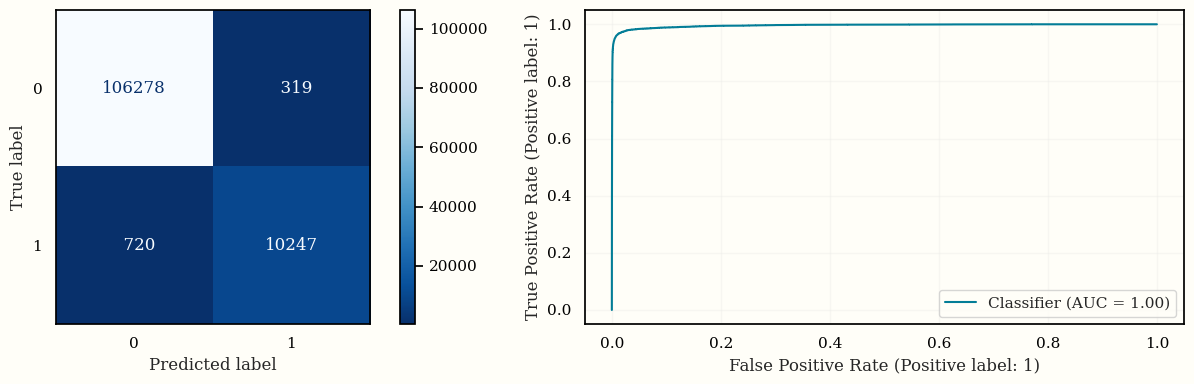

In [47]:
show_confusion_roc(oof)

# Calibration

In [48]:
oof_df = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target'])
oof_df.id = oof_df.id.astype(int)

def probability_calibration_plot(y_true=oof_df.target,
                                 y_preds=oof_df.preds,
                                 y_cali=None,
                                 n_bins=30,
                                 yerr_c=1,
                                 xylim=1,
                                 tick=0.1,
                                 calib_method=''): 
    
    prob_true, prob_pred = calibration_curve(y_true, y_preds, n_bins=n_bins)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=120)
    ax = ax.flatten()
    ax[0].errorbar(x=prob_pred, y=prob_true, yerr=abs(prob_true - prob_pred) * yerr_c, fmt=".k", label='Actual',
                   color=palette[1], capthick=0.5, capsize=3, elinewidth=0.7, ecolor=palette[1])

    sns.lineplot(x=np.linspace(0, xylim, 11), y=np.linspace(0, xylim, 11), color=palette[-3],
                 label='Perfectly calibrated', ax=ax[0], linestyle='dashed')
    
    if isinstance(y_cali, np.ndarray):
        prob_true_, prob_pred_ = calibration_curve(y_true, y_cali, n_bins=n_bins)
        sns.lineplot(x=prob_pred_, y=prob_true_, color=palette[-5],
                     label=f'{calib_method} Calibration', ax=ax[0], linestyle='solid')
    
    sns.histplot(y_preds, bins=n_bins*5, color=palette[1], ax=ax[1])
    for i, _ in enumerate(ax):
        ax[i].xaxis.grid(False)
        ax[i].yaxis.grid(True)

    ax[0].set_title('Probability calibration plot', fontdict={'fontweight': 'bold'})
    ax[1].set_title('Histogram of predictions', fontdict={'fontweight': 'bold'})

    ax[0].set_xticks(list(np.arange(0, xylim + tick, tick)))
    ax[0].set_yticks(list(np.arange(0, xylim + tick, tick)))
    ax[0].set(xlabel='predicted', ylabel='actual')
    fig.suptitle(f'Predictions in range {(0, xylim)}', ha='center',  fontweight='bold', fontsize=16)
    plt.tight_layout();

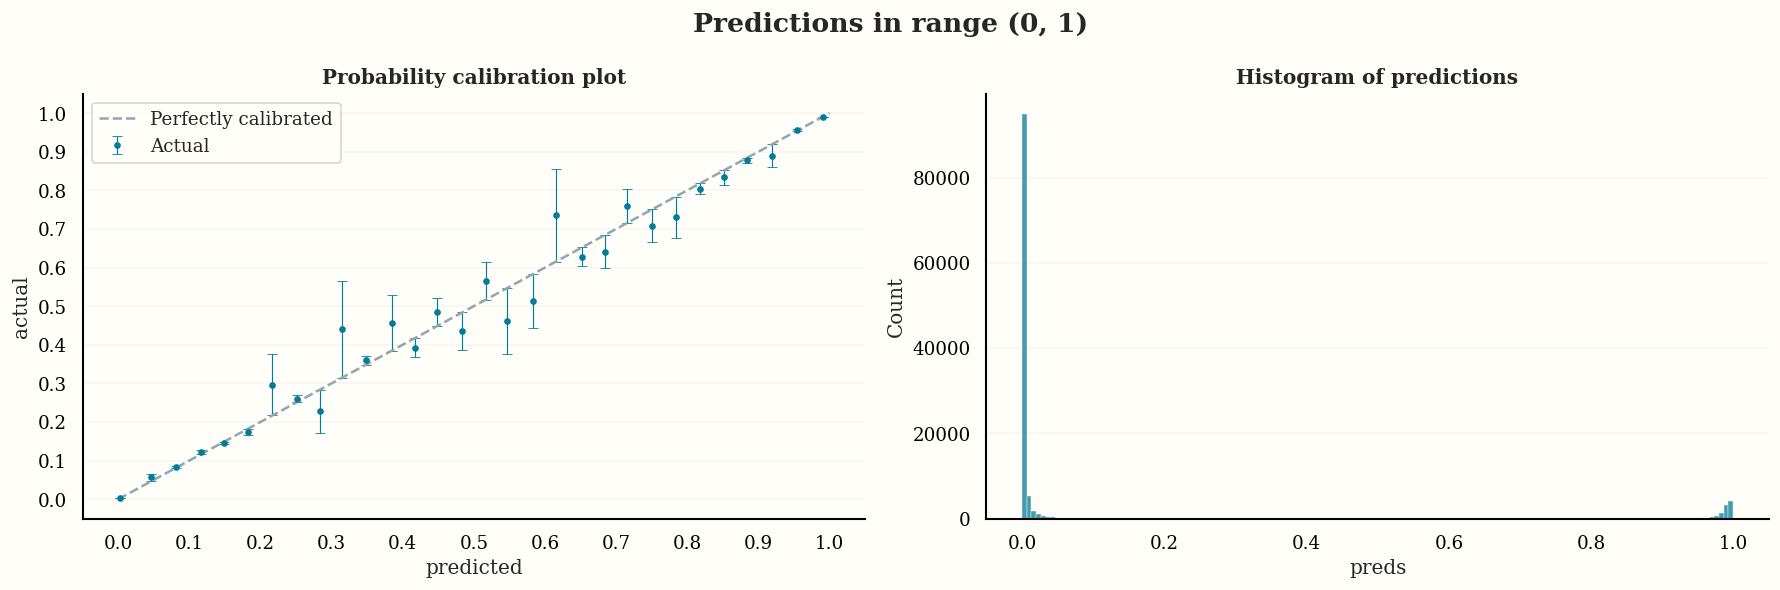

In [49]:
probability_calibration_plot()

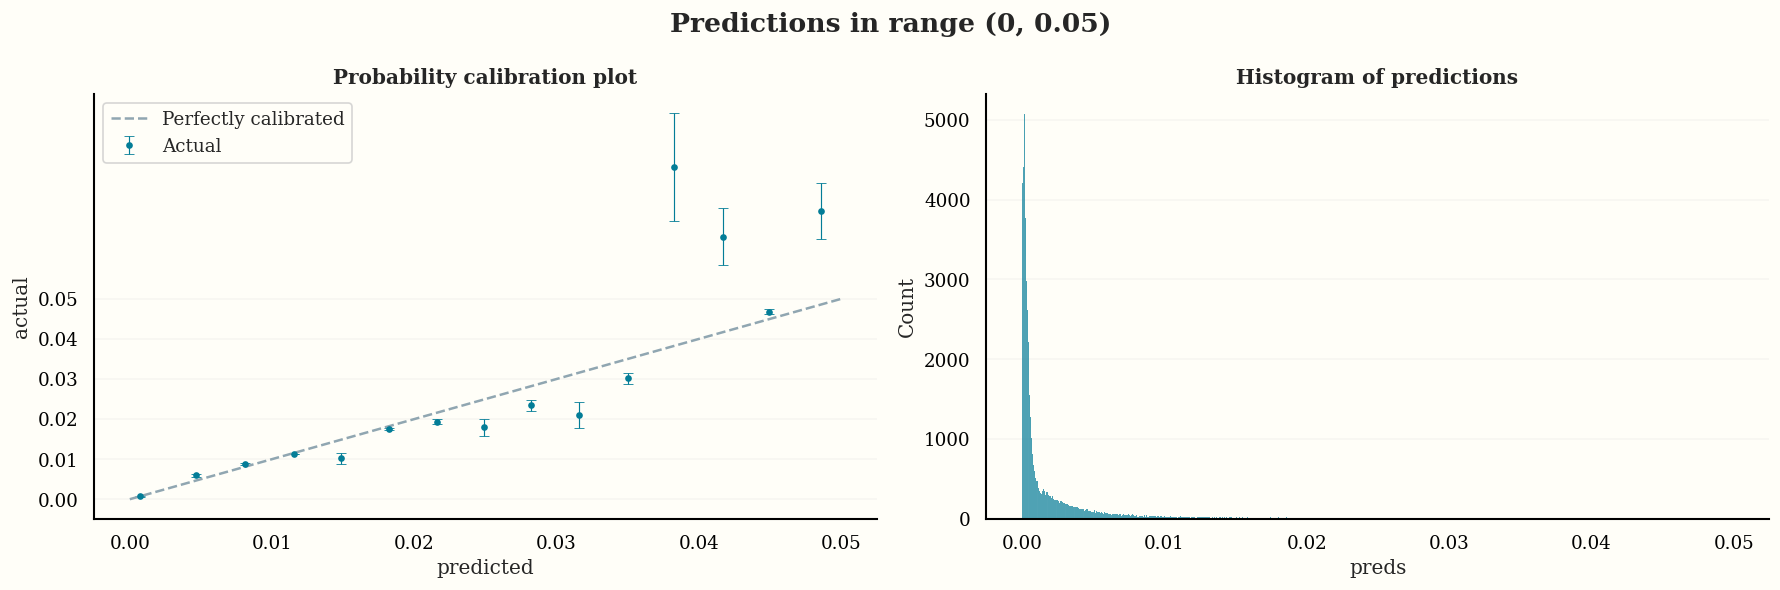

In [50]:
probability_calibration_plot(y_true=oof_df.query('preds < 0.05').target,
                             y_preds=oof_df.query('preds < 0.05').preds,
                             n_bins=300,
                             yerr_c=0.3,
                             xylim=0.05,
                             tick=0.01)

No calibration LogLoss:       0.03104
Platt calibration LogLoss:    0.03794
Isotonic calibration LogLoss: 0.03058




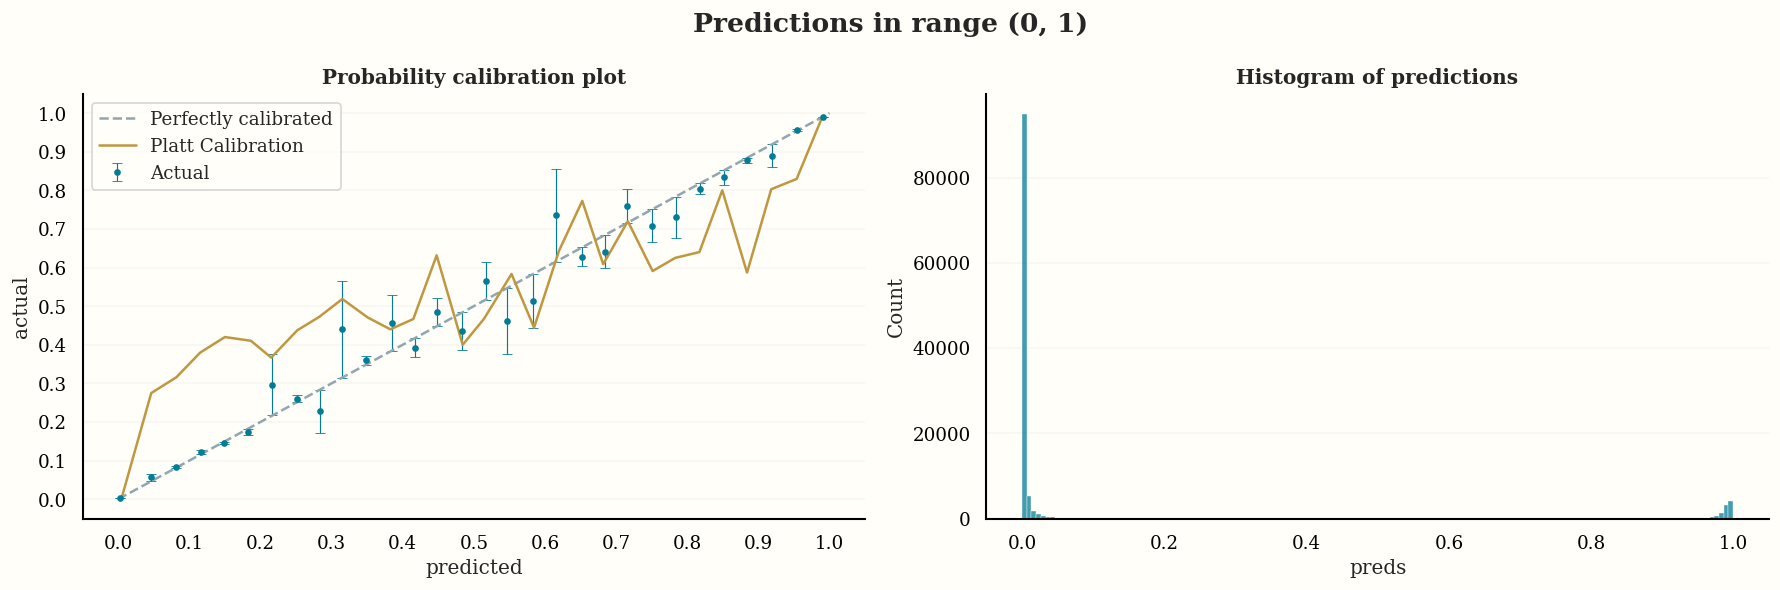

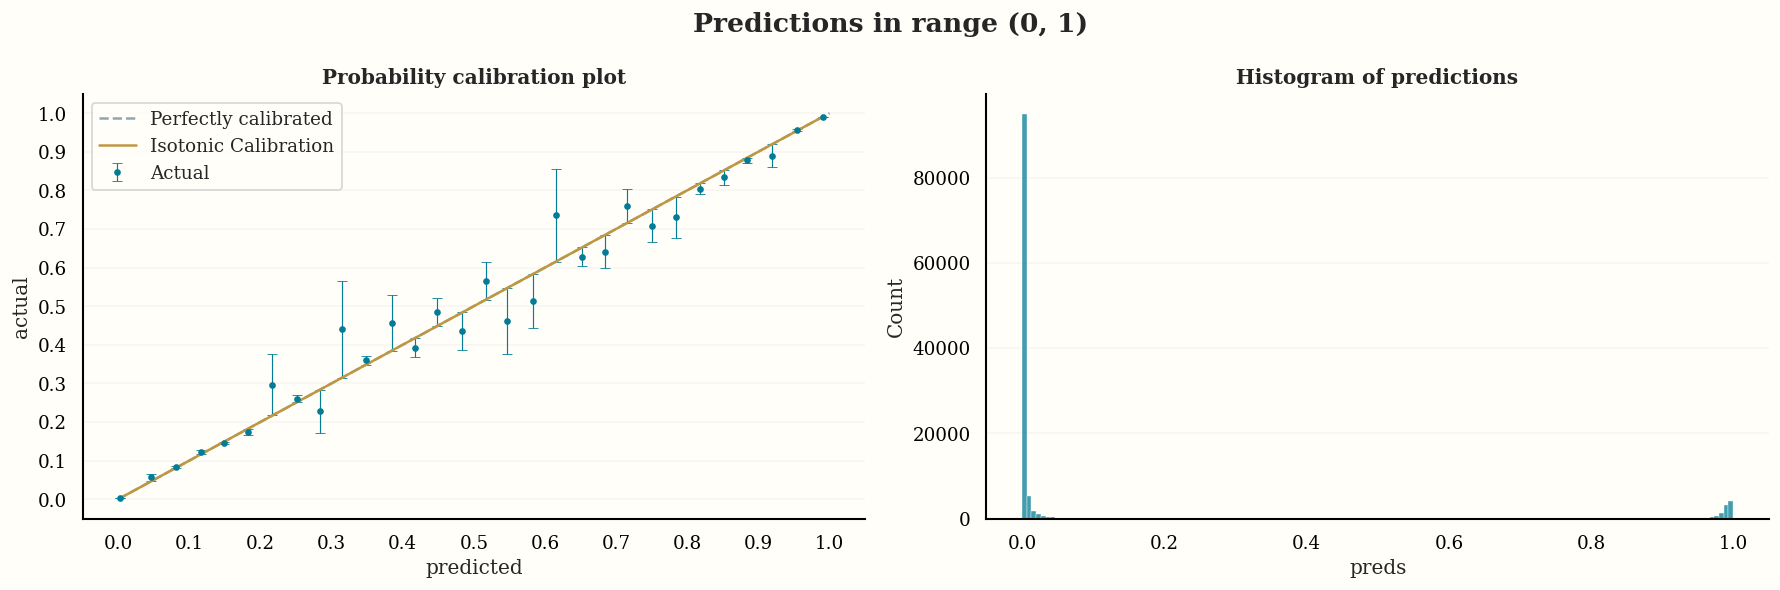

In [51]:
lr = LogisticRegression(C=9999999999, solver='liblinear', max_iter=1000)
lr.fit(oof_df.preds.values.reshape(-1, 1), oof_df.target)
lr_preds_calibrated = lr.predict_proba(oof_df.preds.values.reshape(-1, 1))[:,1]
probability_calibration_plot(y_cali=lr_preds_calibrated, calib_method='Platt')

isor = IsotonicRegression(out_of_bounds='clip')
isor.fit(oof_df.preds.values.reshape(-1, 1), oof_df.target)
isor_preds_calibrated = isor.predict(oof_df.preds.values.reshape(-1, 1))

probability_calibration_plot(y_cali=isor_preds_calibrated, calib_method='Isotonic')
print(f'{gld}No calibration LogLoss:       {res}{log_loss(oof_df.target, oof_df.preds):.5f}')
print(f'{gld}Platt calibration LogLoss:    {red}{log_loss(oof_df.target, lr_preds_calibrated):.5f}{res}')
print(f'{gld}Isotonic calibration LogLoss: {grn}{log_loss(oof_df.target, isor_preds_calibrated):.5f}{res}\n\n')

# Submission

In [52]:
def predict(X):
    y = np.zeros(len(X))
    for model in tqdm(models_):
        y += model.predict(xgb.DMatrix(X))
    return y / len(models_)

predictions = predict(test)
sub = pd.read_csv(os.path.join(CFG.DATA_PATH, 'sample_submission.csv'))
sub.Class = predictions
sub.to_csv('../submissions/submission4.csv', index=False)
sub.head(3)

100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


,id,Class
0,117564,0.00
1,117565,0.00
2,117566,0.00
